<a href="https://colab.research.google.com/github/suntahav/Hackerearth_GardenNerd/blob/master/GardenNerd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
# !pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
!pip3 install https://files.pythonhosted.org/packages/06/e6/a564eba563f7ff53aa7318ff6aaa5bd8385cbda39ed55ba471e95af27d19/torchvision-0.4.0-cp36-cp36m-manylinux1_x86_64.whl
!curl https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip --output dataset.zip
!unzip dataset.zip

In [0]:
!ls ./
# !pip install torchvision

data  dataset.zip  prediction_temp.csv	sample_data


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from torchvision.models import *

In [0]:
bs = 256
my_data_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180, max_zoom=.2,
                      max_lighting=0.07, max_warp=0.)

In [0]:
data = ImageDataBunch.from_csv(path='./data',csv_labels='train.csv',folder='train',ds_tfms= get_transforms(),size=64,suffix='.jpg',valid_pct=0.3,bs=bs)

In [0]:
stats=data.batch_stats()        
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (12978 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
72,58,2,75,51
Path: data;

Valid: LabelList (5562 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
11,19,67,73,73
Path: data;

Test: None

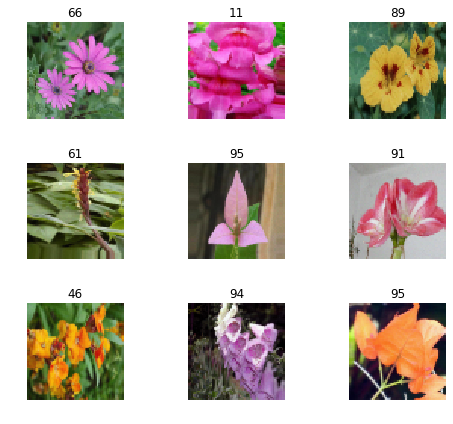

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [0]:
learn = cnn_learner(data,models.resnet101, metrics=[error_rate,accuracy],pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 101MB/s]


In [0]:
learn = learn.to_fp16(dynamic=True)
# learn.lr_find()
# learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.605803,1.533399,0.389069,0.610931,02:51
1,2.141606,0.952497,0.263215,0.736785,02:39
2,1.438000,0.748809,0.214132,0.785868,02:38
3,1.084328,0.714384,0.203164,0.796836,02:38


In [0]:
learn.save('stage-1_64')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

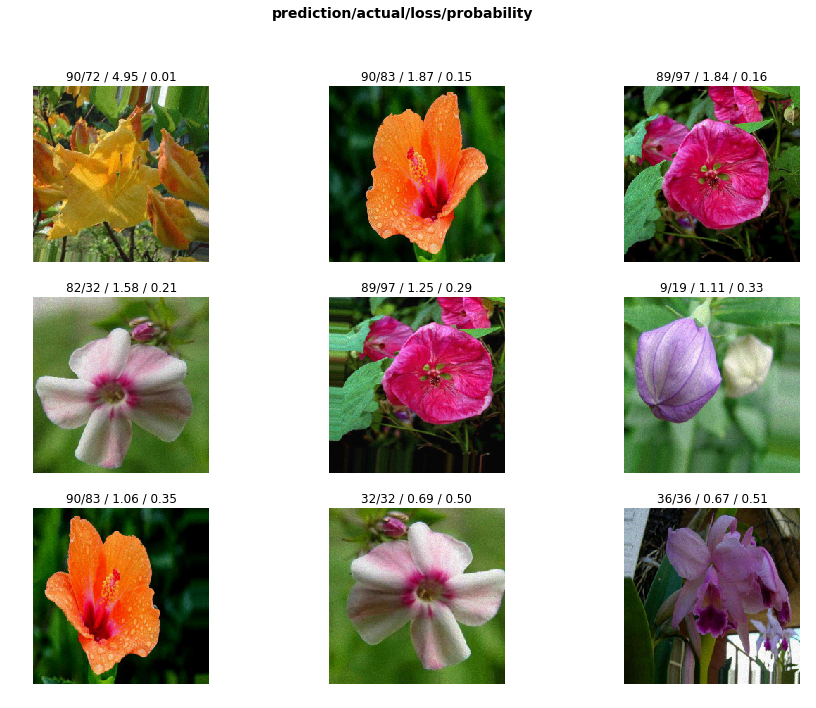

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
interp.most_confused(min_val=2)

[(83, 90, 2), (97, 89, 2)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


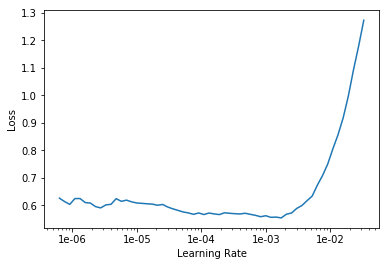

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.519890,0.481667,0.110572,0.889428,02:41
1,0.375319,0.254562,0.074613,0.925387,02:40
2,0.252206,nan,0.062747,0.937253,02:42


In [0]:
learn.save('stage-2_64')

In [0]:
torch.cuda.empty_cache()

In [0]:
bs = 128
data = ImageDataBunch.from_csv(path='./data',csv_labels='train.csv',folder='train',ds_tfms= my_data_tfms,size=128,suffix='.jpg',valid_pct=0.30,bs=bs)
stats=data.batch_stats()        
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (12978 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
77,52,58,2,75
Path: data;

Valid: LabelList (5562 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
73,72,71,77,80
Path: data;

Test: None

In [0]:
learn = cnn_learner(data,models.resnet101, metrics=[error_rate,accuracy],pretrained=True)

In [0]:
learn.to_fp16(dynamic=True)
# learn.load('stage-2_64')

Learner(data=ImageDataBunch;

Train: LabelList (12978 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
77,52,58,2,75
Path: data;

Valid: LabelList (5562 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
73,72,71,77,80
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_siz

In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.526588,0.478656,0.137540,0.862460,03:52
1,0.668243,0.325536,0.088457,0.911543,03:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


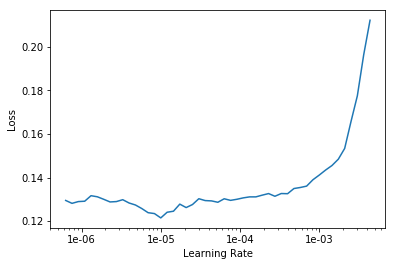

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.139688,nan,0.032183,0.967817,03:57
1,0.137110,nan,0.032722,0.967278,03:56
2,0.144612,0.761652,0.029486,0.970514,03:57


In [0]:
learn.save('stage-2_128')

In [0]:
torch.cuda.empty_cache()
bs = 64
my_data_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180, max_zoom=0.7,
                      max_lighting=0.07, max_warp=0.)
data = ImageDataBunch.from_csv(path='./data',csv_labels='train.csv',folder='train',ds_tfms= my_data_tfms,size=256,suffix='.jpg',valid_pct=0.2,bs=bs)
stats=data.batch_stats()        
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
52,72,58,75,67
Path: data;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
65,89,17,8,20
Path: data;

Test: None

In [0]:
learn = cnn_learner(data,models.resnet101, metrics=[error_rate,accuracy],pretrained=True)
learn.to_fp16(dynamic=True)
learn.load('stage-2_128')

Learner(data=ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
52,72,58,75,67
Path: data;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
65,89,17,8,20
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_siz

In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.434981,nan,0.056634,0.943366,07:38
1,0.232427,2.738220,0.034250,0.965750,07:26


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


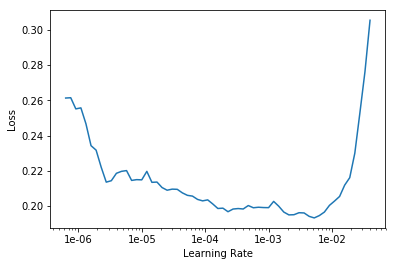

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
# learn.load('stage-3_256_4')
learn.fit_one_cycle(3,max_lr=slice(3e-7,3e-6))

In [0]:
learn.save('stage-3_256')

In [0]:
learn.save('stage-3_256_2')

In [0]:
learn.save('stage-3_256_3')

In [0]:
learn.save('stage-3_256_4')

In [0]:
torch.cuda.empty_cache()
bs = 16
my_data_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180, max_zoom=0.7,
                      max_lighting=0.07, max_warp=0.)
data = ImageDataBunch.from_csv(path='./data',csv_labels='train.csv',folder='train',ds_tfms= my_data_tfms,size=500,suffix='.jpg',valid_pct=0.2,bs=bs)
stats=data.batch_stats()        
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
77,81,52,58,75
Path: data;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
95,100,43,82,3
Path: data;

Test: None

In [0]:
learn = cnn_learner(data,models.resnet152, metrics=[error_rate,accuracy],pretrained=True)
learn.to_fp16(dynamic=True)
# learn.load('stage-3_256')
learn.load('stage-4_500')

Learner(data=ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
77,81,52,58,75
Path: data;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
95,100,43,82,3
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_si

In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.284829,0.080109,0.026699,0.973301,47:11
1,0.124781,0.029405,0.007012,0.992988,46:56


In [0]:
learn.save('stage-4_500')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


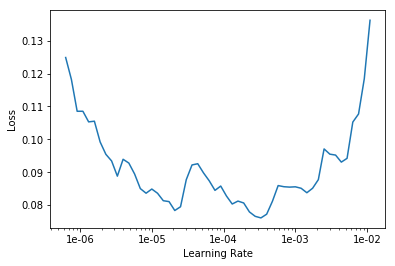

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.107757,0.011691,0.002967,0.997033,57:06
1,0.127192,0.013213,0.003776,0.996224,56:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


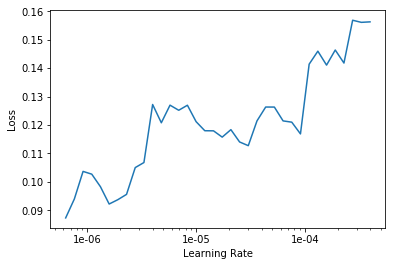

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('stage-4-2_500')

In [0]:
import pandas as pd

In [0]:
test_df = pd.read_csv('./data/test.csv')

In [0]:
result = []
for i in range(0,test_df['image_id'].size):
  res,_,_ =learn.predict(open_image('./data/test/'+str(test_df['image_id'][i])+'.jpg'))
  result.append(int(res.data +1))

In [0]:
test_df.drop(['category'], axis=1)

,image_id
0,18540
1,18541
2,18542
3,18543
4,18544
5,18545
6,18546
7,18547
8,18548
9,18549


In [0]:
test_df['category'] = result

In [0]:
test_df.head()

,image_id,category
0,18540,9
1,18541,40
2,18542,40
3,18543,72
4,18544,51


In [0]:
test_df.to_csv('prediction_temp.csv')

In [0]:
from google.colab import files
files.download('prediction_temp.csv') 

In [0]:
learn.load('stage-3_256')

Learner(data=ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
77,81,52,58,75
Path: data;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
95,100,43,82,3
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_si